In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
import zipfile
import os
import torch

# -----------------------------
# 1. EKSTRAK ZIP (jika belum diekstrak)
# -----------------------------
ZIP_FILE = 'Vehicle Image Classification.zip'  # Ganti jika nama file berbeda
DATA_DIR = './dataset/Vehicles'  # Folder hasil ekstraksi

# Cek apakah sudah diekstrak
if not os.path.exists(DATA_DIR):
    with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
        print(f"Dataset diekstrak ke: {DATA_DIR}")

# -----------------------------
# 2. PARAMETER
# -----------------------------
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 0.001
IMG_SIZE = 128
MODEL_SAVE_PATH = 'trained_model_cnn.pth'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Jumlah gambar per kelas:
- Auto Rickshaws: 800 gambar
- Bikes: 800 gambar
- Cars: 790 gambar
- Motorcycles: 800 gambar
- Planes: 800 gambar
- Ships: 800 gambar
- Trains: 800 gambar


c:\KULIAH\SEMS 7\Machine Learning\Klasifikasi jenis kendaraan\venv\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


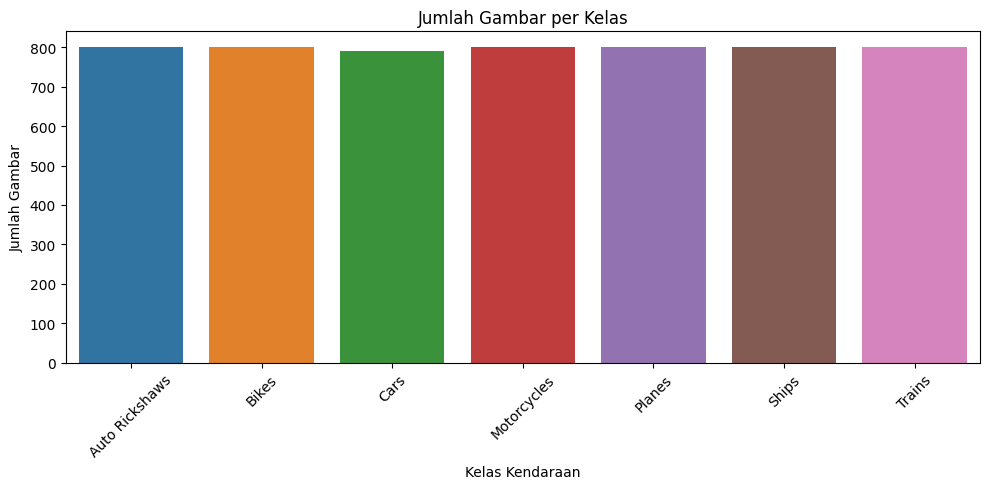

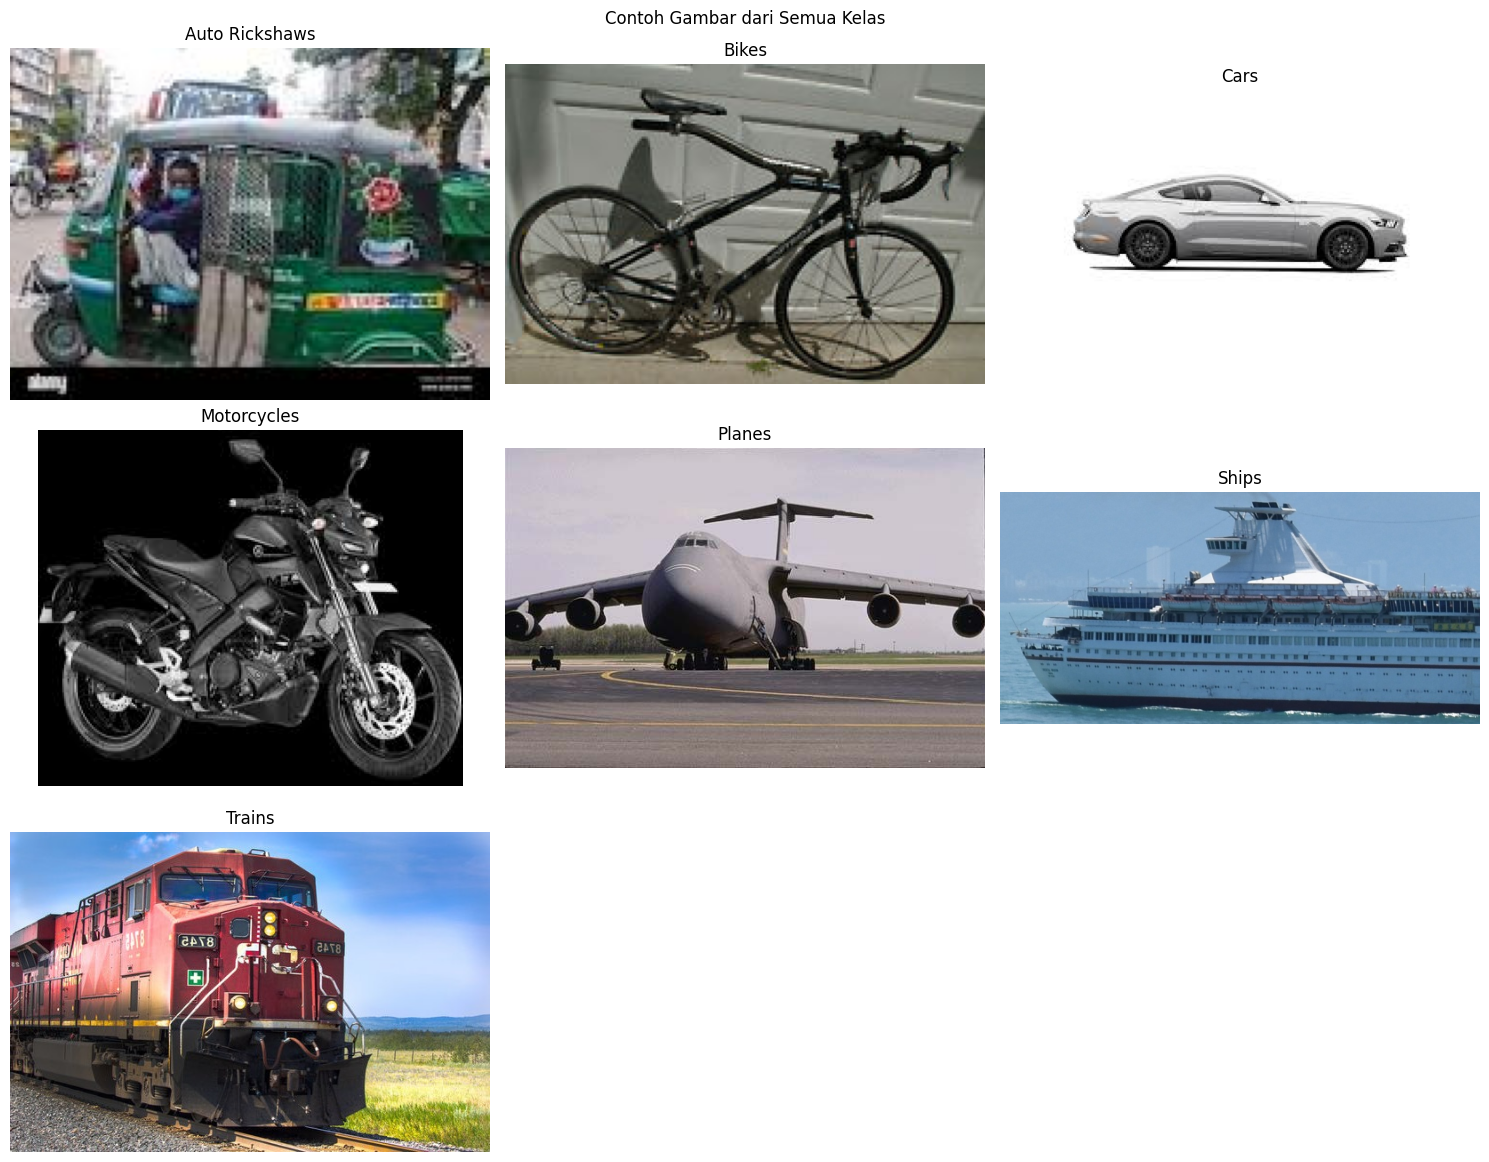


Ukuran asli gambar per kelas:
- Auto Rickshaws: (140, 140) (lebar x tinggi)
- Bikes: (225, 169) (lebar x tinggi)
- Cars: (275, 183) (lebar x tinggi)
- Motorcycles: (1920, 1080) (lebar x tinggi)
- Planes: (800, 490) (lebar x tinggi)
- Ships: (6000, 4000) (lebar x tinggi)
- Trains: (700, 490) (lebar x tinggi)


In [3]:
# -----------------------------
# EDA - Exploratory Data Analysis
# -----------------------------
import os
from PIL import Image
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Jumlah gambar per kelas
class_counts = {}
for class_name in os.listdir(DATA_DIR):
    class_path = os.path.join(DATA_DIR, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# ✅ Tampilkan jumlah gambar per kelas (teks)
print("Jumlah gambar per kelas:")
for class_name, count in class_counts.items():
    print(f"- {class_name}: {count} gambar")

# ✅ Visualisasi distribusi data
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Jumlah Gambar per Kelas')
plt.xlabel('Kelas Kendaraan')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. ✅ Tampilkan contoh gambar dari semua kelas secara dinamis
sample_classes = list(class_counts.keys())
num_classes = len(sample_classes)
cols = 3
rows = math.ceil(num_classes / cols)

plt.figure(figsize=(5 * cols, 4 * rows))
for idx, class_name in enumerate(sample_classes):
    class_path = os.path.join(DATA_DIR, class_name)
    sample_img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, sample_img_name)
    image = Image.open(img_path)

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(image)
    plt.title(f"{class_name}")
    plt.axis('off')

plt.suptitle("Contoh Gambar dari Semua Kelas")
plt.tight_layout()
plt.show()

# 3. ✅ Cek ukuran gambar (untuk konfirmasi resize nanti)
image_shapes = []
for class_name in class_counts.keys():
    class_path = os.path.join(DATA_DIR, class_name)
    sample_img_path = os.path.join(class_path, os.listdir(class_path)[0])
    with Image.open(sample_img_path) as img:
        image_shapes.append(img.size)

print("\nUkuran asli gambar per kelas:")
for idx, class_name in enumerate(class_counts.keys()):
    print(f"- {class_name}: {image_shapes[idx]} (lebar x tinggi)")


In [4]:
# -----------------------------
# 2. PREPROCESSING DATA
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [5]:
import os
import shutil
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# -----------------------------
# 1. HAPUS FOLDER OUTPUT JIKA SUDAH ADA
# -----------------------------
ORIGINAL_DATASET = './dataset/Vehicles'  # Folder awal berisi semua kelas
OUTPUT_DIR = './data_split'     # Folder output
SPLITS = ['train', 'val', 'test']
RATIOS = [0.7, 0.2, 0.1]  # Train 70%, Val 20%, Test 10%

# Jika folder data_split sudah ada, hapus dulu biar tidak konflik
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)

# -----------------------------
# 2. BUAT FOLDER TRAIN/VAL/TEST PER KELAS
# -----------------------------
for split in SPLITS:
    for class_name in os.listdir(ORIGINAL_DATASET):
        class_dir = os.path.join(ORIGINAL_DATASET, class_name)
        if os.path.isdir(class_dir):
            dest_dir = os.path.join(OUTPUT_DIR, split, class_name)
            os.makedirs(dest_dir, exist_ok=True)

# -----------------------------
# 3. PISAHKAN GAMBAR KE FOLDER YANG SESUAI
# -----------------------------
for class_name in os.listdir(ORIGINAL_DATASET):
    class_dir = os.path.join(ORIGINAL_DATASET, class_name)
    if os.path.isdir(class_dir):
        # Hanya ambil file gambar
        images = [
            f for f in os.listdir(class_dir)
            if os.path.isfile(os.path.join(class_dir, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        random.shuffle(images)
        n_total = len(images)
        n_train = int(RATIOS[0] * n_total)
        n_val = int(RATIOS[1] * n_total)

        splits = {
            'train': images[:n_train],
            'val': images[n_train:n_train + n_val],
            'test': images[n_train + n_val:]
        }

        for split in SPLITS:
            for img in splits[split]:
                src_path = os.path.join(class_dir, img)
                dst_path = os.path.join(OUTPUT_DIR, split, class_name, img)
                # Cek ulang jika file sumber ada
                if os.path.exists(src_path):
                    shutil.copy2(src_path, dst_path)

print("✅ Dataset berhasil dipisah ke dalam folder train, val, dan test.\n")

# -----------------------------
# 4. LOAD DATA DENGAN ImageFolder
# -----------------------------
BATCH_SIZE = 16
IMG_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformasi (preprocessing)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load ImageFolder
train_data = datasets.ImageFolder(os.path.join(OUTPUT_DIR, 'train'), transform=transform)
val_data = datasets.ImageFolder(os.path.join(OUTPUT_DIR, 'val'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(OUTPUT_DIR, 'test'), transform=transform)
class_names = train_data.classes  # Sama untuk semua split

# DataLoader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Info
print(f"Jumlah kelas: {len(class_names)} - {class_names}")
print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")


✅ Dataset berhasil dipisah ke dalam folder train, val, dan test.

Jumlah kelas: 7 - ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']
Train size: 3910
Validation size: 1117
Test size: 560


In [6]:
# -----------------------------
# 4. MODEL CNN (DEEPER VERSION)
# -----------------------------
import torch
import torch.nn as nn
from torchsummary import summary  # pastikan sudah diinstall dengan pip install torchsummary

# CNN lebih dalam
class DeeperCNN(nn.Module):
    def __init__(self, num_classes):
        super(DeeperCNN, self).__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128 -> 64

            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 32

            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16

            # Conv Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16 -> 8
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Inisialisasi model dan pindahkan ke device
model = DeeperCNN(num_classes=len(class_names)).to(DEVICE)

# Tampilkan struktur model
summary(model, input_size=(3, IMG_SIZE, IMG_SIZE))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           9,248
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
         MaxPool2d-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          18,496
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]          36,928
      BatchNorm2d-12           [-1, 64, 64, 64]             128
             ReLU-13           [-1, 64, 64, 64]               0
        MaxPool2d-14           [-1, 64,

In [7]:
# -----------------------------
# 5. TRAINING SETUP (Improved)
# -----------------------------
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer (with weight decay for regularization)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Learning Rate Scheduler (Reduce LR on plateau of val_loss)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Lists for plotting
train_loss_list = []
val_loss_list = []
val_acc_list = []


In [8]:
print(f"Jumlah data train: {len(train_data)}")
print(f"Jumlah data validasi: {len(val_data)}")
print(f"Jumlah batch train: {len(train_loader)}")
print(f"Jumlah batch val: {len(val_loader)}")
print(f"Jumlah kelas: {len(class_names)} - {class_names}")

# Ambil satu batch untuk melihat shape
inputs, labels = next(iter(train_loader))
print(f"Input shape: {inputs.shape}")  # Contoh: torch.Size([16, 3, 128, 128])


Jumlah data train: 3910
Jumlah data validasi: 1117
Jumlah batch train: 245
Jumlah batch val: 70
Jumlah kelas: 7 - ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']
Input shape: torch.Size([16, 3, 128, 128])


In [9]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

# -----------------------------
# 6. TRAINING LOOP
# -----------------------------

# Setup early stopping parameters
best_val_loss = float('inf')
patience = 5
counter = 0

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    acc = correct / total

    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {acc:.4f}")

    # Step scheduler
    scheduler.step(avg_val_loss)

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), MODEL_SAVE_PATH)  # save best model
    else:
        counter += 1
        if counter >= patience:
            print(f"\n⛔ Early stopping triggered at epoch {epoch+1}")
            break

# ✅ Final save: only state_dict (recommended)
torch.save(model.state_dict(), MODEL_SAVE_PATH)
torch.save(model.state_dict(), "cnn_model_complete.pth")


c:\KULIAH\SEMS 7\Machine Learning\Klasifikasi jenis kendaraan\venv\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20 - Train Loss: 2.0957 - Val Loss: 1.2265 - Val Acc: 0.5282
Epoch 2/20 - Train Loss: 1.2038 - Val Loss: 1.0472 - Val Acc: 0.6168
Epoch 3/20 - Train Loss: 1.0775 - Val Loss: 0.8840 - Val Acc: 0.6670
Epoch 4/20 - Train Loss: 0.9493 - Val Loss: 0.8081 - Val Acc: 0.7216
Epoch 5/20 - Train Loss: 0.8542 - Val Loss: 0.8227 - Val Acc: 0.7108
Epoch 6/20 - Train Loss: 0.7989 - Val Loss: 0.6175 - Val Acc: 0.7923
Epoch 7/20 - Train Loss: 0.7238 - Val Loss: 0.7126 - Val Acc: 0.7520
Epoch 8/20 - Train Loss: 0.6459 - Val Loss: 0.7116 - Val Acc: 0.7654
Epoch 9/20 - Train Loss: 0.6061 - Val Loss: 0.6248 - Val Acc: 0.7941
Epoch 10/20 - Train Loss: 0.5716 - Val Loss: 0.6285 - Val Acc: 0.7968
Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.
Epoch 11/20 - Train Loss: 0.4404 - Val Loss: 0.4628 - Val Acc: 0.8594
Epoch 12/20 - Train Loss: 0.3877 - Val Loss: 0.4203 - Val Acc: 0.8639
Epoch 13/20 - Train Loss: 0.3605 - Val Loss: 0.3776 - Val Acc: 0.8711
Epoch 14/20 - Train Loss: 0.3472 - Va

In [10]:
dummy = torch.randn(1, 3, 224, 224)
model = DeeperCNN(num_classes=7)
out = model.features(dummy)
print(out.shape)  # <- lihat hasilnya


torch.Size([1, 256, 14, 14])



Classification Report:
                precision    recall  f1-score   support

Auto Rickshaws       0.88      0.81      0.85       160
         Bikes       0.98      0.96      0.97       160
          Cars       0.81      0.88      0.84       158
   Motorcycles       0.94      0.92      0.93       160
        Planes       0.88      0.82      0.85       159
         Ships       0.74      0.86      0.80       160
        Trains       0.88      0.85      0.87       160

      accuracy                           0.87      1117
     macro avg       0.88      0.87      0.87      1117
  weighted avg       0.88      0.87      0.87      1117


Confusion Matrix:


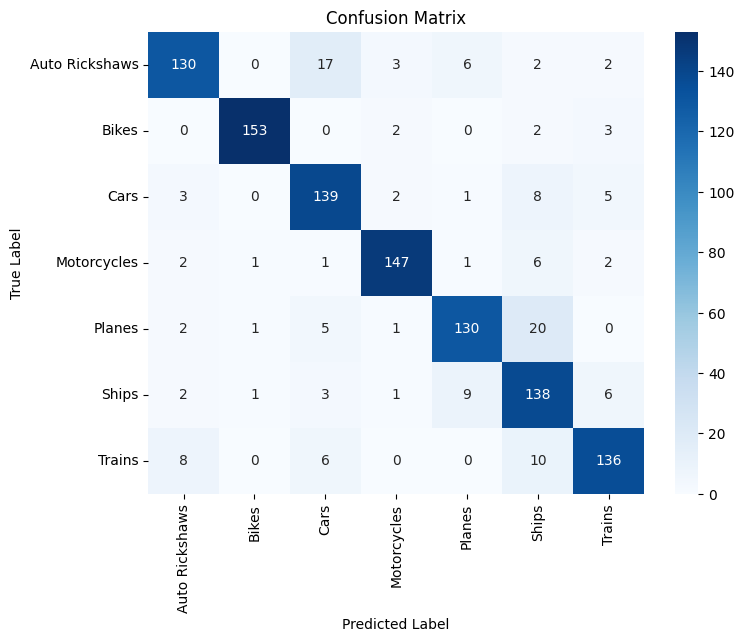

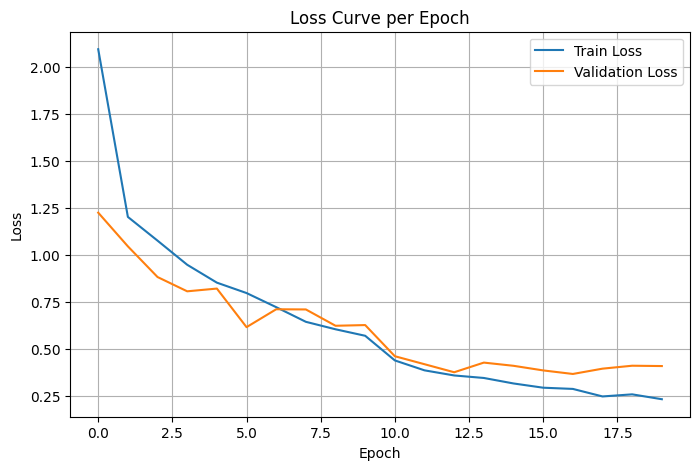

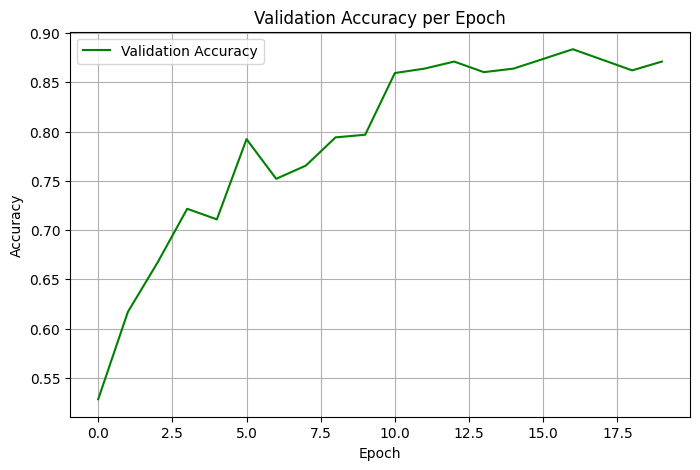

In [11]:
# -----------------------------
# 7. EVALUATION
# -----------------------------
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# 2. Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 3. Loss Curve
plt.figure(figsize=(8,5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# 4. Accuracy Curve
plt.figure(figsize=(8,5))
plt.plot(val_acc_list, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

def classify_image(image_path, model, class_names, target_size=(128, 128)):
    model.eval()

    # Transformasi sesuai training
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
    ])

    # Load dan proses gambar
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(DEVICE)

    # Prediksi
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)

    predicted_class = class_names[predicted_idx.item()]
    confidence = confidence.item() * 100

    # Visualisasi hasil
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()

    return predicted_class


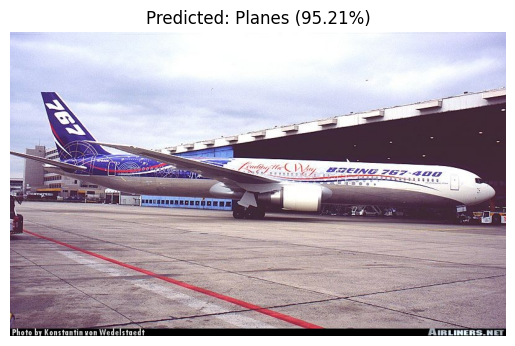

Hasil klasifikasi: Planes


In [44]:
# Pemanggilan fungsi dengan path (perhatikan raw string atau double slash)
image_path = r"C:\KULIAH\SEMS 7\Machine Learning\Klasifikasi jenis kendaraan\dataset\Vehicles\Planes\Plane (1).jpg"
hasil = classify_image(image_path, model, class_names)
print(f"Hasil klasifikasi: {hasil}")

# -----------------------------
#       MODEL PRETRAINED
# -----------------------------

In [14]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# -----------------------------
# PARAMETER
# -----------------------------
DATA_DIR = './data_split'
BATCH_SIZE = 16
IMG_SIZE = 224
LEARNING_RATE = 1e-4
EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# -----------------------------
# TRANSFORM
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])  # ImageNet normalization
])


In [17]:
# -----------------------------
# LOAD DATA
# -----------------------------
train_data = ImageFolder(os.path.join(DATA_DIR, 'train'), transform=transform)
val_data = ImageFolder(os.path.join(DATA_DIR, 'val'), transform=transform)
test_data = ImageFolder(os.path.join(DATA_DIR, 'test'), transform=transform)

class_names = train_data.classes

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)


In [18]:
# -----------------------------
# MODEL SELECTION FUNCTION
# -----------------------------
def get_pretrained_model(model_name, num_classes):
    if model_name == 'mobilenet':
        model = models.mobilenet_v2(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    elif model_name == 'efficientnet':
        model = EfficientNet.from_pretrained('efficientnet-b0')
        for param in model.parameters():
            param.requires_grad = False
        model._fc = nn.Linear(model._fc.in_features, num_classes)
    else:
        raise ValueError("Model harus 'mobilenet' atau 'efficientnet'")
    
    return model.to(DEVICE)


In [19]:
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, model_name, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), 
        lr=LEARNING_RATE
    )
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    train_loss_list, val_loss_list, val_acc_list = [], [], []

    for epoch in range(EPOCHS):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        # Validation
        model.eval()
        running_val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_train_loss = running_train_loss / len(train_loader)
        avg_val_loss = running_val_loss / len(val_loader)
        acc = correct / total

        train_loss_list.append(avg_train_loss)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(acc)

        print(f"[{model_name}] Epoch {epoch+1}/{EPOCHS} - "
              f"Train Loss: {avg_train_loss:.4f} - "
              f"Val Loss: {avg_val_loss:.4f} - "
              f"Val Acc: {acc:.4f}")

        # Scheduler step
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"⛔ Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), f'{model_name}_pretrained.pth')
    print(f"✅ Model terbaik disimpan sebagai: {model_name}_pretrained.pth")

    return train_loss_list, val_loss_list, val_acc_list


In [20]:
# -----------------------------
# EVALUATION FUNCTION
# -----------------------------
def evaluate_model(model, model_name):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    print(f"\n=== {model_name.upper()} Classification Report ===")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()


Loaded pretrained weights for efficientnet-b0


c:\KULIAH\SEMS 7\Machine Learning\Klasifikasi jenis kendaraan\venv\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[efficientnet] Epoch 1/10 - Train Loss: 1.5213 - Val Loss: 1.0900 - Val Acc: 0.9382
[efficientnet] Epoch 2/10 - Train Loss: 0.9569 - Val Loss: 0.7450 - Val Acc: 0.9579
[efficientnet] Epoch 3/10 - Train Loss: 0.6992 - Val Loss: 0.5558 - Val Acc: 0.9669
[efficientnet] Epoch 4/10 - Train Loss: 0.5406 - Val Loss: 0.4399 - Val Acc: 0.9660
[efficientnet] Epoch 5/10 - Train Loss: 0.4562 - Val Loss: 0.3713 - Val Acc: 0.9714
[efficientnet] Epoch 6/10 - Train Loss: 0.3913 - Val Loss: 0.3168 - Val Acc: 0.9740
[efficientnet] Epoch 7/10 - Train Loss: 0.3493 - Val Loss: 0.2776 - Val Acc: 0.9767
[efficientnet] Epoch 8/10 - Train Loss: 0.3194 - Val Loss: 0.2518 - Val Acc: 0.9776
[efficientnet] Epoch 9/10 - Train Loss: 0.2902 - Val Loss: 0.2300 - Val Acc: 0.9776
[efficientnet] Epoch 10/10 - Train Loss: 0.2765 - Val Loss: 0.2101 - Val Acc: 0.9785
✅ Model terbaik disimpan sebagai: efficientnet_pretrained.pth

=== EFFICIENTNET Classification Report ===
                precision    recall  f1-score   suppo

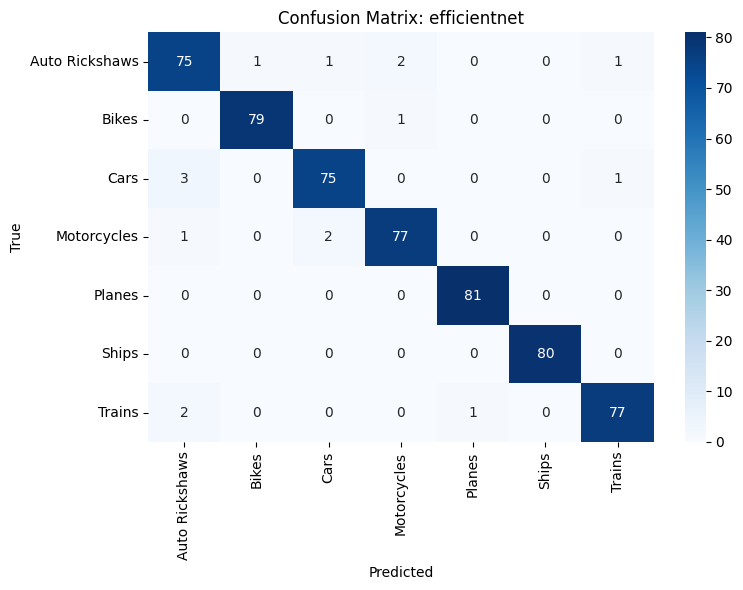

In [21]:
# -----------------------------
# RUN MODEL: EfficientNet-B0
# -----------------------------
effnet_model = get_pretrained_model('efficientnet', len(class_names))
train_model(effnet_model, 'efficientnet')
evaluate_model(effnet_model, 'efficientnet')


c:\KULIAH\SEMS 7\Machine Learning\Klasifikasi jenis kendaraan\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\KULIAH\SEMS 7\Machine Learning\Klasifikasi jenis kendaraan\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\KULIAH\SEMS 7\Machine Learning\Klasifikasi jenis kendaraan\venv\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[mobilenet] Epoch 1/10 - Train Loss: 1.1985 - Val Loss: 0.6208 - Val Acc: 0.9543
[mobilenet] Epoch 2/10 - Train Loss: 0.5498 - Val Loss: 0.3349 - Val Acc: 0.9714
[mobilenet] Epoch 3/10 - Train Loss: 0.3639 - Val Loss: 0.2306 - Val Acc: 0.9714
[mobilenet] Epoch 4/10 - Train Loss: 0.2794 - Val Loss: 0.1856 - Val Acc: 0.9749
[mobilenet] Epoch 5/10 - Train Loss: 0.2314 - Val Loss: 0.1528 - Val Acc: 0.9776
[mobilenet] Epoch 6/10 - Train Loss: 0.2019 - Val Loss: 0.1317 - Val Acc: 0.9794
[mobilenet] Epoch 7/10 - Train Loss: 0.1785 - Val Loss: 0.1225 - Val Acc: 0.9794
[mobilenet] Epoch 8/10 - Train Loss: 0.1669 - Val Loss: 0.1121 - Val Acc: 0.9812
[mobilenet] Epoch 9/10 - Train Loss: 0.1497 - Val Loss: 0.0988 - Val Acc: 0.9785
[mobilenet] Epoch 10/10 - Train Loss: 0.1455 - Val Loss: 0.0958 - Val Acc: 0.9794
✅ Model terbaik disimpan sebagai: mobilenet_pretrained.pth

=== MOBILENET Classification Report ===
                precision    recall  f1-score   support

Auto Rickshaws       0.95      0

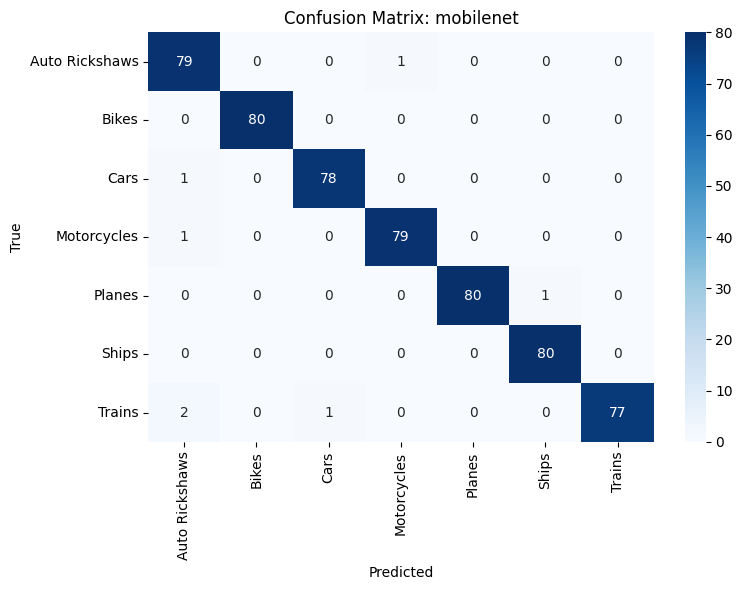

In [22]:
# -----------------------------
# RUN MODEL: MobileNetV2
# -----------------------------
mobilenet_model = get_pretrained_model('mobilenet', len(class_names))
train_model(mobilenet_model, 'mobilenet')
evaluate_model(mobilenet_model, 'mobilenet')

In [23]:
# -----------------------------
# Save Pretrained Model
# -----------------------------
torch.save(effnet_model.state_dict(), "efficientnet_model.pth")
torch.save(mobilenet_model.state_dict(), "mobilenet_model.pth")

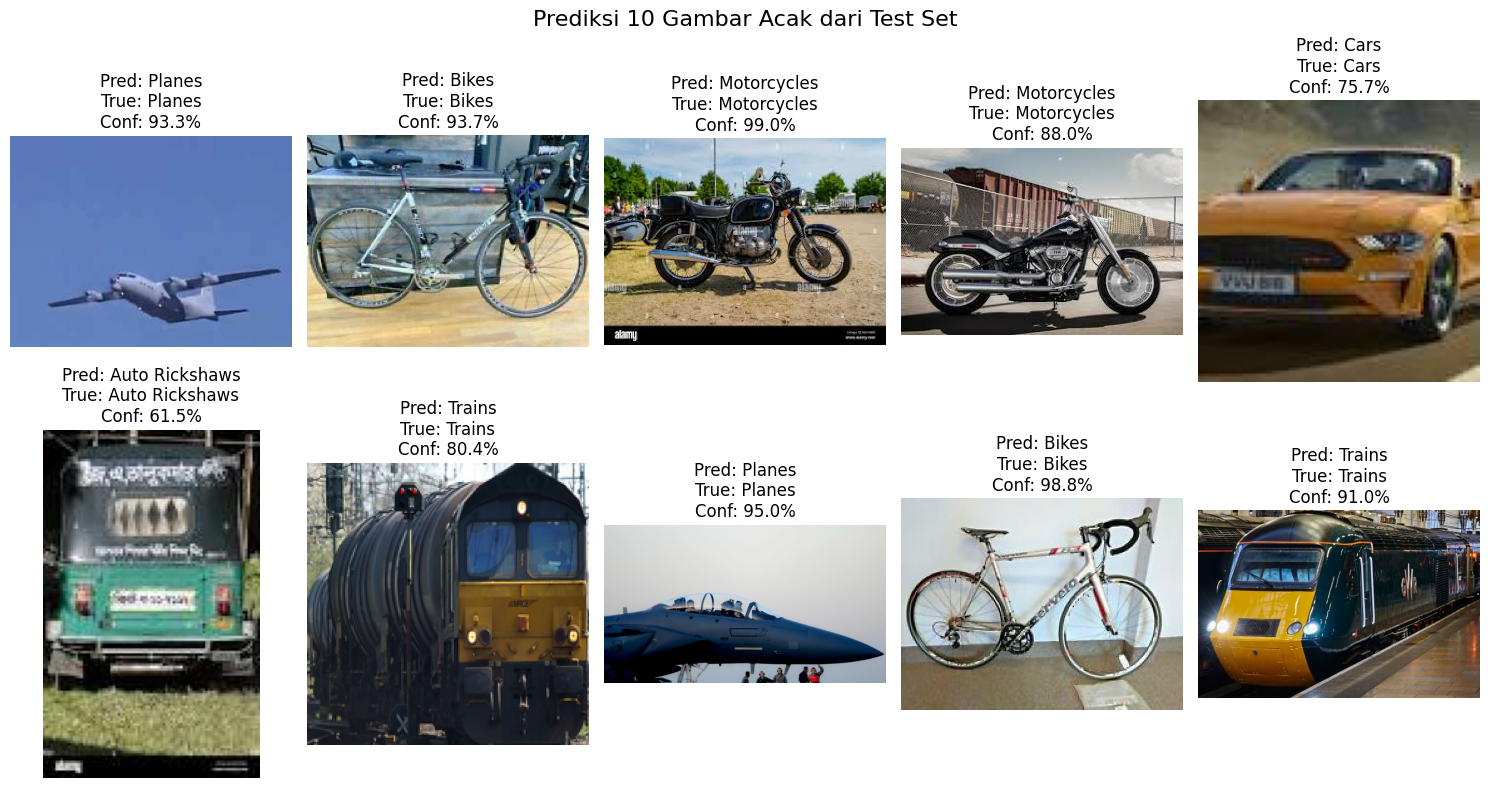

In [24]:
# -----------------------------
# 11. PREDIKSI 10 GAMBAR TEST SET (Pretrained)
# -----------------------------
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# ✅ Gunakan transformasi yang sama seperti saat training model pretrained
pretrained_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# ✅ Fungsi klasifikasi 1 gambar
def classify_image(image_path, model, class_names, transform, device):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)

    predicted_class = class_names[predicted_idx.item()]
    confidence = confidence.item() * 100
    return predicted_class, confidence, image

# ✅ Ambil 10 gambar acak dari test set
TEST_DIR = os.path.join(DATA_DIR, 'test')  # Gunakan DATA_DIR jika sebelumnya didefinisikan
sample_images = []

for class_name in os.listdir(TEST_DIR):
    class_folder = os.path.join(TEST_DIR, class_name)
    if os.path.isdir(class_folder):
        images = [f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        sampled = random.sample(images, min(2, len(images)))  # Ambil maksimal 2 per kelas
        for img in sampled:
            sample_images.append((os.path.join(class_folder, img), class_name))

sample_images = random.sample(sample_images, min(10, len(sample_images)))  # Total 10 gambar

# ✅ Tentukan model pretrained yang akan digunakan (ganti sesuai model yang kamu pakai)
model = effnet_model  # atau: model = mobilenet_model

# 🔍 Prediksi dan visualisasi
plt.figure(figsize=(15, 8))
for idx, (img_path, true_class) in enumerate(sample_images):
    pred_class, conf, image = classify_image(img_path, model, class_names, pretrained_transform, DEVICE)
    plt.subplot(2, 5, idx + 1)
    plt.imshow(image)
    plt.title(f"Pred: {pred_class}\nTrue: {true_class}\nConf: {conf:.1f}%")
    plt.axis('off')

plt.suptitle("Prediksi 10 Gambar Acak dari Test Set", fontsize=16)
plt.tight_layout()
plt.show()
